# Credit Card Fraud Classifier
## IEOR 290
**Author:** Sixu Meng

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import sklearn

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer, FunctionTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

# Objective
The purpose of this homework is to walk  through the data science cycle towards building a classical machine learning model.

* Explore the provided dataset
* Develop visualizations
* Formulate the hypothesis
* Clean and reformat the dataset to help you build a predictive model
* Develop features
* Build a predictive model

In [2]:
data = pd.read_csv("hw_data.csv")
data.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15.0,0.0,253460.0,427174.0,0.0,0.0


# Part 1: Data Cleaning
In this part, we will guide you through cleaning the dataset and prepare it for data exploration.

### **Question 1**: What are some potential problems with the above dataset? 

#### 1.Garbage entry: It appears that there is a garbage entry in end of this dataset
#### 2.Abnormal Values: e.g. Current Loan Amount has 99999999.0 value stored in the columns, e.g. Credit Score have value larger than 1000
#### 3.Redundancy of values: e.g. Purpose has 'other' and 'Other' which both indicate other type.
#### 4.Missing of values: e.g columns hold NaN value in different rows

### **Question 2**: Several columns have missing data. Discuss how you would deal with missing data in each column, implement the changes and save it in the variable 'data_clean'

* **Loan ID:** *Drop the rows where all elements are missing.remove all duplicated row if having same loan ID (assuming loan ID as primary key here)*
* **Customer ID:** *Drop the rows where all elements are missing.*
* **Loan Status:** *Keep it*
* **Current Loan Amount:** *Remove abnormal loan amount 99999999*
* **Term:** *Keep it*
* **Credit Score:** *Remove if credit score smaller than 300 or larger than 850*
* **Annual Income:** *Keep it*
* **Years in current job:** *Drop NaN*
* **Home Ownership:** *Keep it*
* **Purpose:** *str.lower with each value to keep the consistency*
* **Monthly Debt:** *Keep it*
* **Years of Credit History:** *Keep it*
* **Number of Credit Problems:** *Keep it*
* **Current Credit Balance:** *Keep it*
* **Maximum Open Credit:** *Keep it*
* **Bankruptcies:** *Drop NaN*
* **Tax Liens:** *Drop NaN*

In [3]:
# Drop the rows where all elements are missing. 
data_clean = data.dropna(how='all').copy()
data_clean = data_clean.drop_duplicates(subset=['Loan ID'])
data_clean = data_clean[data_clean['Current Loan Amount']!=99999999.0]
data_clean = data_clean[data_clean['Credit Score']<=850]
data_clean = data_clean[data_clean['Credit Score']>=300]
data_clean = data_clean[data_clean['Years in current job'].isna()!=True]
data_clean['Purpose'] = data_clean['Purpose'].str.lower()
data_clean['Months since last delinquent'] = data_clean['Months since last delinquent'].fillna((data_clean['Months since last delinquent'].mean()),inplace = False)
data_clean = data_clean[data_clean['Bankruptcies'].isna()!=True]
data_clean = data_clean[data_clean['Tax Liens'].isna()!=True]

<!--
BEGIN QUESTION
name: q2a_cleaning_any_nan
manual: false
points: 1
-->

# Part 2: Data Exploration

### **Question 3:** Create three interesting visualizations that will help you build a hypothesis.

* What are some numerical indicators that point towards a charged-off loan?
* How does the purpose of the loan impact the loan application? 
* How does the house ownership status impact the loan application?

**Visualization 1**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

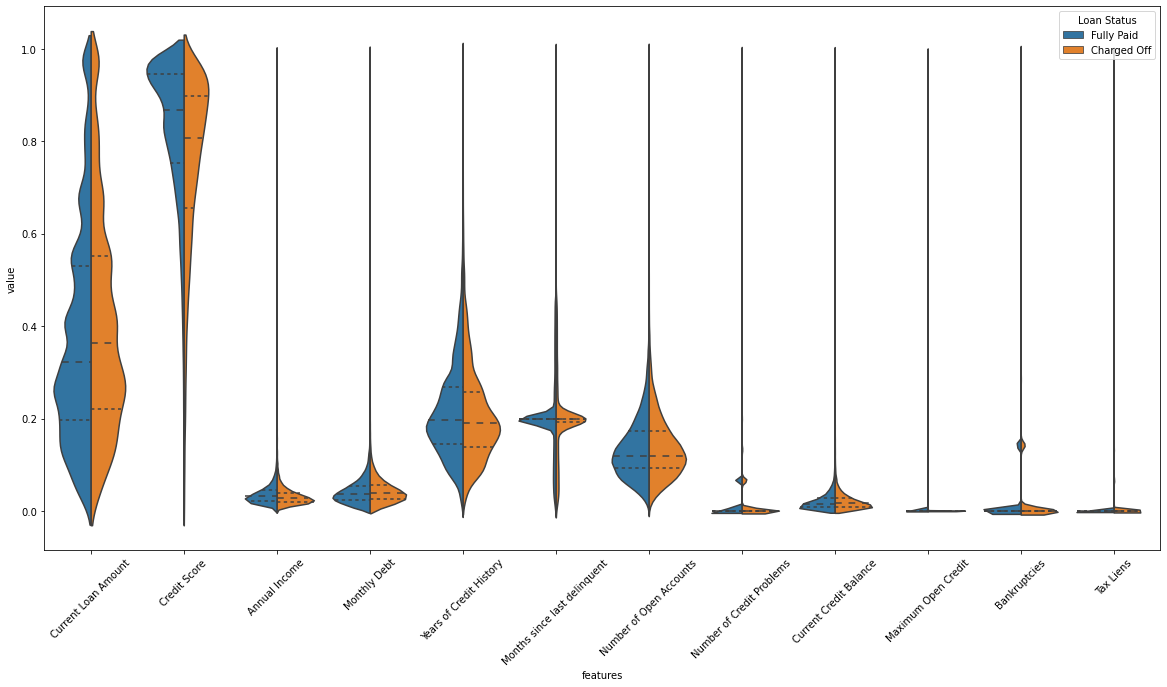

In [10]:
from pandas.api.types import is_numeric_dtype
numerical_col = []
for i in data_clean.columns:
    if is_numeric_dtype(data_clean[i]):
        numerical_col.append(i)
data_loan = data_clean["Loan Status"]
data_num = data_clean[numerical_col]
data_n_2 = (data_num-data_num.min())/(data_num.max()-data_num.min())# standardization: it maka more sense with mean normalized data

data_num = pd.concat([data_clean["Loan Status"],data_n_2.iloc[:,:]],axis=1)
data_num = pd.melt(data_num,id_vars="Loan Status",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(20,10))
sns.violinplot(x="features", y="value", hue="Loan Status", data=data_num,split=True, inner="quartile", cut=1)
plt.xticks(rotation=45)

**What insights does this visualization offer?**

From all the above numerical feactures, We can see that 
1. *Current Loan Amount* have a overall **higher** distribution with charged-off loan. 
2. *Years of Credit History* have a overall **lower** distribution with charged-off loan. 

**Visualization 2**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

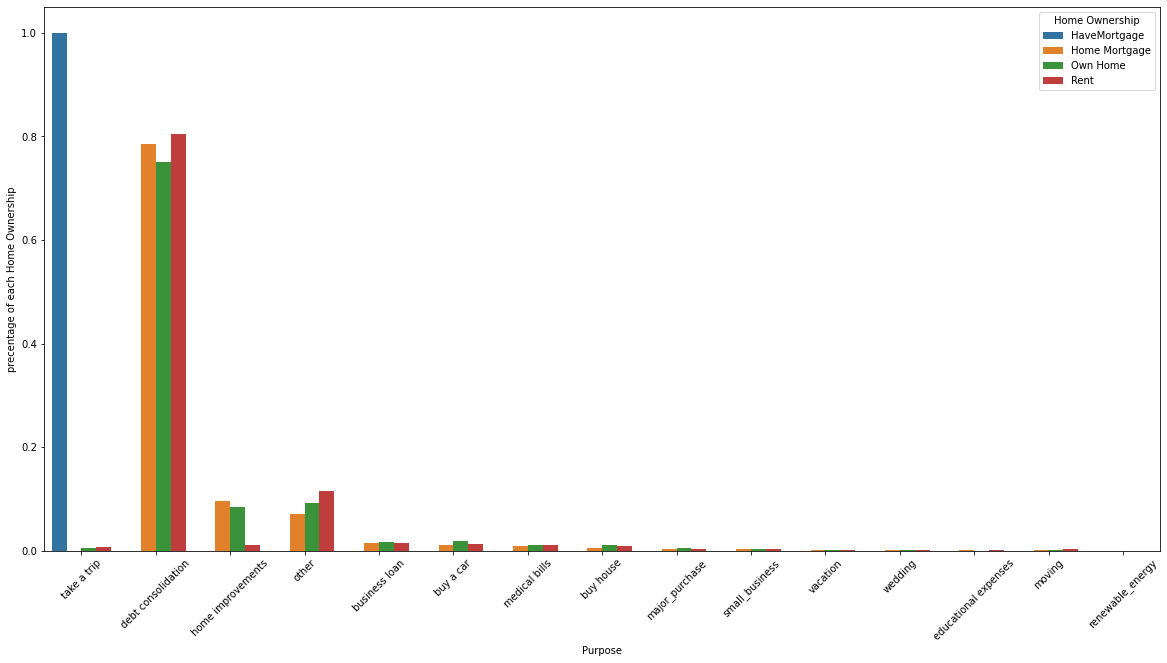

In [11]:

# sns.catplot(x="Credit Score", y="Purpose", data=data_clean)
# sns.catplot(x="Purpose", y="Credit Score", hue="Loan Status", kind="swarm", data=data_clean)
# g = sns.catplot(x="Annual Income", y="Purpose", hue="Loan Status", kind="box", data=data_clean,)
# g.fig.set_figwidth(8.27)
# g.fig.set_figheight(11.7)

# g = sns.catplot(x="Loan Status", col="Purpose", col_wrap=4,
#                 data=data_clean,
#                 kind="count", height=2.5, aspect=.8)

# df = sns.load_dataset("tips")

x, y, hue = "Purpose", "precentage of each Home Ownership", "Home Ownership"
# hue_order = ["Charged Off", "Fully Paid "]

plt.figure(figsize=(20,10))
# sns.countplot(x=x, hue=hue, data=data_clean, ax=axes[0])

prop_df = (data_clean[x]
           .groupby(data_clean[hue])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

sns.barplot(x=x, y=y, hue=hue, data=prop_df)
plt.xticks(rotation=45)

**What insights does this visualization offer?**

From the visualization above we can found that there's a very high chance from people *haveMortgage* take lone for *take a trip* purpose comparing to other three type of home ownership.

**Visualization 3**

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

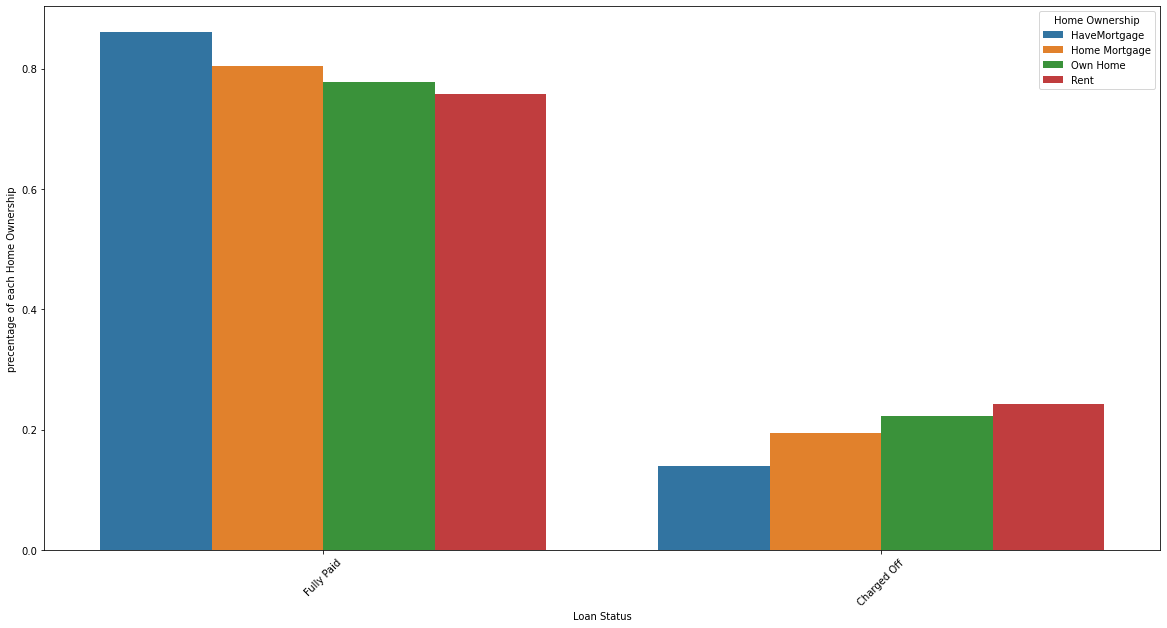

In [12]:

# sns.catplot(x="Credit Score", y="Purpose", data=data_clean)
# sns.catplot(x="Purpose", y="Credit Score", hue="Loan Status", kind="swarm", data=data_clean)
# g = sns.catplot(x="Annual Income", y="Purpose", hue="Loan Status", kind="box", data=data_clean,)
# g.fig.set_figwidth(8.27)
# g.fig.set_figheight(11.7)

# g = sns.catplot(x="Loan Status", col="Purpose", col_wrap=4,
#                 data=data_clean,
#                 kind="count", height=2.5, aspect=.8)

# df = sns.load_dataset("tips")

x, y, hue = "Loan Status", "precentage of each Home Ownership", "Home Ownership"
# hue_order = ["Charged Off", "Fully Paid "]

plt.figure(figsize=(20,10))
# sns.countplot(x=x, hue=hue, data=data_clean, ax=axes[0])

prop_df = (data_clean[x]
           .groupby(data_clean[hue])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

sns.barplot(x=x, y=y, hue=hue, data=prop_df)
plt.xticks(rotation=45)

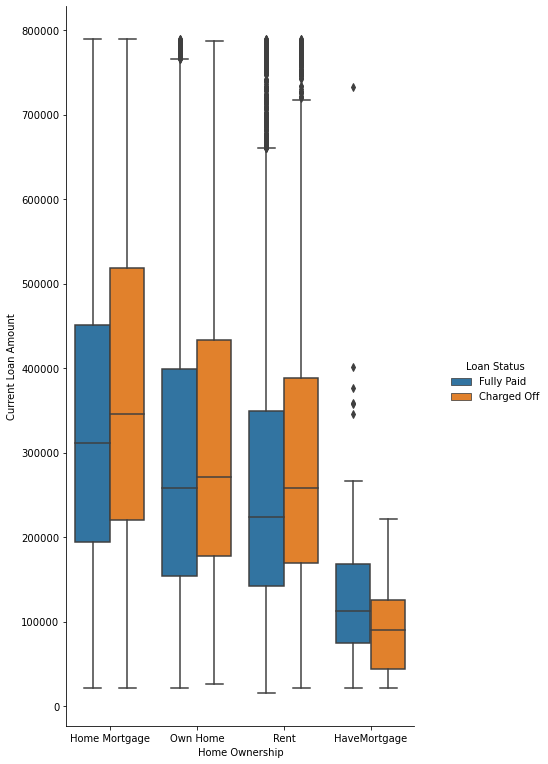

In [13]:
g = sns.catplot(x="Home Ownership", y="Current Loan Amount", hue="Loan Status", kind="box", data=data_clean,)
g.fig.set_figwidth(8.27)
g.fig.set_figheight(11.7)

**What insights does this visualization offer?**

1. We found that people **have Mortgage** tend to loan **less** then other three types of mortgages.
2. We found that people **have Mortgage** tend to *fully paid* loans having **larger** amount, however, people tend to **charged off** loan having **larger** amount with other type of mortages.

### **Question 4:** What is your hypothesis?

*The Term of the Loan is a feature that can predict Loan Status*

### **Question 5:** Analyze the dataset and make an inference about your hypothesis.

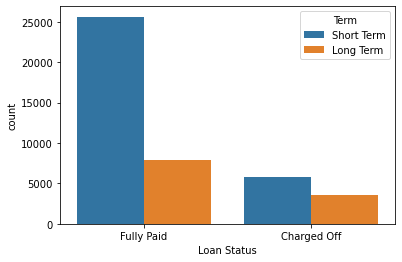

In [14]:
sns.countplot(x='Loan Status', hue="Term", data=data_clean)
# plt.xticks(range(2),['Made it','Deceased']);

/Users/sixumeng/opt/anaconda3/envs/data-x/lib/python3.7/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Text(0.5, 15.0, 'Term (Short Term = 1)')

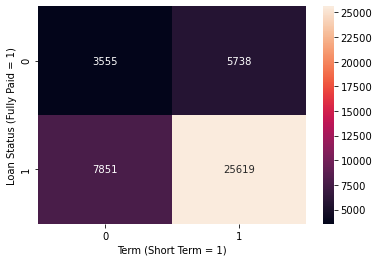

In [15]:
# Write the code for your analysis here
from sklearn.metrics import f1_score,confusion_matrix

test_hypo = data_clean[['Term','Loan Status']]
test_hypo.loc[:,'Loan Status'] = (data_clean['Loan Status'] == 'Fully Paid').copy()
cm_2 = confusion_matrix((data_clean['Loan Status'] == 'Fully Paid'),(data_clean['Term'] == 'Short Term'))
sns.heatmap(cm_2,annot=True,fmt="d")
plt.ylabel("Loan Status (Fully Paid = 1)")
plt.xlabel("Term (Short Term = 1)")

*Therefore we find these two variable are strongly correlated with each other*

# Part 3: Preprocessing and Feature Engineering

 The objective you are working towards is building a classifier that will allow you to classify whether a loan will be fully paid or charged off using some or all of the following pieces of data: 
* Loan ID
* Customer ID
* Loan Status
* Current Loan Amount
* Term
* Credit Score
* Annual Income
* Years in current job
* Home Ownership
* Purpose
* Monthly Debt
* Years of Credit History
* Months since last delinquent
* Number of Open Accounts
* Number of Credit Problems
* Current Credit Balance
* Maximum Open Credit
* Bankruptcies
* Tax Liens

This notebook contains a reference implementation that uses *Number of Open Accounts*, *Monthly Debt*, *Bankruptcies*, and *Home Ownership* to predict *Loan Status*. These features are not sufficient to achieve the accuracy threshold required for this assignment. You should use this code as an example and a scaffold for your own solution. 

### **Question 6:** Which metrics do you think are good indicators of loan status?  Create a new Dataframe preprocessed_data with all the columns (at least 4) that you determine to be good indicators of loan status.

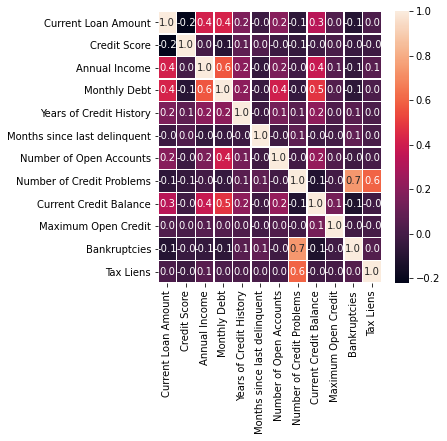

In [16]:
# start by finding correlation between numerical data
f,ax = plt.subplots(figsize=(5, 5))
sns.heatmap(data_clean.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

*As it can be seen in map heat figure Number of Credit Problem, Bankruptices and Tax Lines are correlated with each other so we will use only Bankruptices and Tax Line.*


In [17]:
take_list = ['Current Loan Amount', 'Term',
       'Credit Score', 'Annual Income', 'Years in current job',
       'Home Ownership', 'Purpose', 'Monthly Debt', 'Years of Credit History',
       'Months since last delinquent', 'Number of Open Accounts',
       'Current Credit Balance',
       'Maximum Open Credit', 'Bankruptcies', 'Tax Liens']

In [18]:
x_1 = data_clean[take_list].copy()
y = data_clean['Loan Status'] == 'Fully Paid'

one_hot_data = pd.get_dummies(x_1[take_list],drop_first=True)
def upsample(X, y):
    each_ct = len(y[y])
    assert len(y[~y]) < each_ct
    X0, y0 = sklearn.utils.resample(X[~y], y[~y], replace=True, n_samples=each_ct)
    X1, y1 = X[y], y[y]
    return np.concatenate([X0, X1]), np.concatenate([y0, y1])
x,y = upsample(one_hot_data,y)
x = pd.DataFrame(data = x,columns = one_hot_data.columns)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

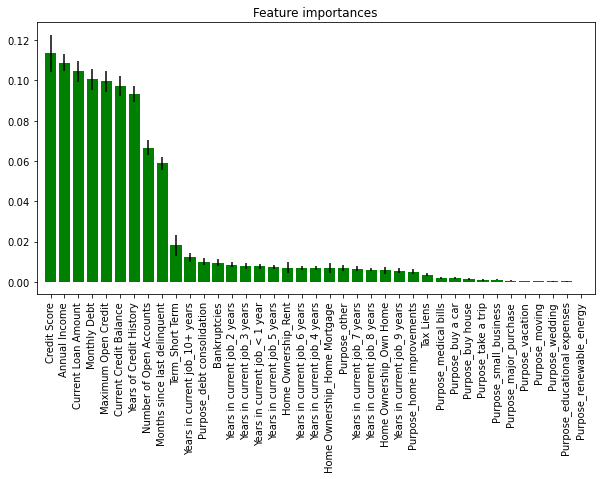

In [20]:
clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(x_train,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf_5.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
# print("Feature ranking:")

# for f in range(x_train.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(10, 5))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices],rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()

In [21]:
# Use feature importance as measurement for feature selection, we see top 7 can cover over 70% importance
selected_columns = x_train.columns[indices][:7]
def select_columns():
    ft = FunctionTransformer(lambda x: x[selected_columns])
    ft.get_feature_names = lambda: selected_columns
    return ft
selected_columns

Index(['Credit Score', 'Annual Income', 'Current Loan Amount', 'Monthly Debt',
       'Maximum Open Credit', 'Current Credit Balance',
       'Years of Credit History'],
      dtype='object')

In [22]:
# Review the feature building pipeline to ensure that it looks as you expect
select_pipeline = make_pipeline(select_columns())
select_pipeline.fit_transform(data_clean).head()

,Credit Score,Annual Income,Current Loan Amount,Monthly Debt,Maximum Open Credit,Current Credit Balance,Years of Credit History
0,709.0,1167493.0,445412.0,5214.74,416746.0,228190.0,17.2
3,721.0,806949.0,347666.0,8741.90,386958.0,256329.0,12.0
5,730.0,1184194.0,217646.0,10855.08,272052.0,122170.0,19.6
6,678.0,2559110.0,548746.0,18660.28,555038.0,437171.0,22.6
7,739.0,1454735.0,215952.0,39277.75,1021460.0,669560.0,13.9


<!--
BEGIN QUESTION
name: q6a_select_columns
manual: false
points: 1
-->

In [23]:
grader.check("q6a_select_columns")

All tests passed!

### **Question 7:** Are the numerical features useful for prediction in their current form? Modify the code below to ensure the numerical features are formatted suitably.

In [24]:
def numerical_transforms():
    return ColumnTransformer([
        # Edit this section so that it includes your chosen features
        ('Credit Score', StandardScaler(), ['Credit Score']),
        ('Annual Income', StandardScaler(), ['Annual Income']),
        ('Current Loan Amount', StandardScaler(), ['Current Loan Amount']),
        ('Monthly Debt', StandardScaler() , ['Monthly Debt']),
        ('Maximum Open Credit', StandardScaler(), ['Maximum Open Credit']),
        ('Current Credit Balance', StandardScaler(), ['Current Credit Balance']),
        ('Years of Credit History', KBinsDiscretizer(n_bins=10, encode="ordinal",strategy="quantile"), ['Years of Credit History']),
    ],

        remainder='passthrough')

# Review the feature building pipeline to ensure that it looks as you expect
num_pipeline = make_pipeline(select_columns(), numerical_transforms())
pd.DataFrame(num_pipeline.fit_transform(data_clean), columns=selected_columns).head()

,Credit Score,Annual Income,Current Loan Amount,Monthly Debt,Maximum Open Credit,Current Credit Balance,Years of Credit History
0,-0.371056,-0.250983,0.733641,-1.086220,-0.042892,-0.185544,5.0
1,0.057657,-0.640568,0.200893,-0.800412,-0.046417,-0.108434,1.0
2,0.379193,-0.232937,-0.507759,-0.629179,-0.060012,-0.476072,6.0
3,-1.478566,1.252726,1.296845,0.003282,-0.026530,0.387130,7.0
4,0.700728,0.059396,-0.516992,1.673930,0.028655,1.023950,2.0


<!--
BEGIN QUESTION
name: q7a_numerical_transform_columns
manual: false
points: 1
-->

### **Question 8:** Convert all your non-numerical features to numerical form that you believe would be useful for your model.

In [27]:
def categorical_transforms():
    # Edit this ColumnTransformer to account for your chosen features
    return ColumnTransformer([
        ('Years of Credit History', OneHotEncoder(sparse=False), [list(selected_columns).index('Years of Credit History')])],
        remainder='passthrough')

full_pipeline = make_pipeline(select_columns(), numerical_transforms(), categorical_transforms())

# Review the feature building pipeline to ensure that it looks as you expect
full_pipeline.fit_transform(data_clean)[:5]


array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.37105613, -0.25098316,  0.73364088, -1.08621999, -0.04289212,
        -0.18554369],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.05765739, -0.64056828,  0.20089279, -0.8004117 , -0.04641652,
        -0.10843393],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.37919253, -0.23293692, -0.50775929, -0.62917922, -0.06001174,
        -0.476072  ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        -1.47856605,  1.2527259 ,  1.29684542,  0.00328171, -0.02652996,
         0.38713031],
       [ 0.        ,  0.        ,  1

<!--
BEGIN QUESTION
name: q8a_categorical_transform_rows
manual: false
points: 1
-->

In [28]:
grader.check("q8a_categorical_transform_rows")

All tests passed!

# Part 4: Model Building

We are now ready to build a model. We tranform the cleaned data from Part 1 using the features defined in Part 3. Then we split it into training, validation, and test data sets. Before fitting, we balance the data by resampling to achieve an equal number of positive and negative outcomes in each data set.

In [29]:
full_pipeline.fit(data_clean)
X = full_pipeline.transform(data_clean)
y = data_clean['Loan Status'] == 'Fully Paid'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.34, random_state=43)

def upsample(X, y):
    each_ct = len(y[y])
    assert len(y[~y]) < each_ct
    X0, y0 = sklearn.utils.resample(X[~y], y[~y], replace=True, n_samples=each_ct)
    X1, y1 = X[y], y[y]
    return np.concatenate([X0, X1]), np.concatenate([y0, y1])

X_train, y_train = upsample(X_train, y_train)
X_validation, y_validation = upsample(X_validation, y_validation)
X_test, y_test = upsample(X_test, y_test)

In [30]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Frequency of unique valu es of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique valu es of the said array:
[[    0     1]
 [25083 25083]]


### **Question 9:** Implement and compare three of the following classification models and determine what works best for the problem and your choice of features.
1. Logistic Regression
2. K-Nearest Neighbors (KNN) 
3. Support Vector Machines (SVM)
4. Perceptron
5. XGBoost
6. Random Forest

Be sure to use:
* X_train, y_train to train the models in Question 9a, 9b,..., 9f
* X_validation, y_validation to validate the models in Question 9a, 9b,..., 9f
* X_test, y_test to test the best model in Question 10

#### Question 9a: Logistic Regression

In [31]:
# Choose at least for models to implement - your code here
logreg = LogisticRegression(max_iter=1000)                                # instantiate
logreg.fit(X_train, y_train)                                 
y_prediction = logreg.predict(X_validation)                               # predict
acc_logreg = sum(y_prediction == y_validation)/len(y_validation)*100      # evaluate

print('Logistic Regression validation accuracy:', str(round(acc_logreg,2)),'%')

Logistic Regression validation accuracy: 60.03 %


#### Question 9b: KNN

In [32]:
# Choose at least for models to implement - your code here
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=78)
neigh.fit(X_train, y_train)
y_prediction = neigh.predict(X_validation)                               # predict
acc_knn = sum(y_prediction == y_validation)/len(y_validation)*100      # evaluate
print('KNN validation accuracy:', str(round(acc_knn,2)),'%')

KNN validation accuracy: 59.43 %


#### Question 9c: SVM

In [33]:
# Choose at least for models to implement - your code here
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)
y_prediction = clf.predict(X_validation)                               # predict
acc_svm = sum(y_prediction == y_validation)/len(y_validation)*100      # evaluate
print('SVM validation accuracy:', str(round(acc_svm,2)),'%')

SVM validation accuracy: 60.57 %


#### Question 9d: Perceptron

In [34]:
# Choose at least for models to implement - your code here
clf_p = Perceptron(tol=1e-3, random_state=43)
clf_p.fit(X_train, y_train)
y_prediction = clf_p.predict(X_validation)                               # predict
acc_percep = sum(y_prediction == y_validation)/len(y_validation)*100      # evaluate
print('Perceptron validation accuracy:', str(round(acc_percep,2)),'%')

Perceptron validation accuracy: 55.46 %


#### Question 9e: XGBoost

In [35]:
## HyperParameter Tuning
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
# xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
#                     silent=True, nthread=1)
# # xgb_model.fit(X_train, y_train)
# # y_prediction = xgb_model.predict(X_validation)                               # predict
# # acc_logreg = sum(y_prediction == y_validation)/len(y_validation)*100      # evaluate
# # print('XGBoost:', str(round(acc_logreg,2)),'%')
# folds = 3
# param_comb = 5
# params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }
# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
# random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train, y_train), verbose=3, random_state=1001 )
# # Here we go
# random_search.fit(X_train, y_train)


In [36]:
# print('\n All results:')
# print(random_search.cv_results_)
# print('\n Best estimator:')
# print(random_search.best_estimator_)
# print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
# print(random_search.best_score_ * 2 - 1)
# print('\n Best hyperparameters:')
# print(random_search.best_params_)

In [37]:
xgb_model = XGBClassifier(colsample_bytree=0.8, gamma=1.5, learning_rate=0.02, max_depth=5,
              n_estimators=600, nthread=1, silent=True, subsample=0.6)

xgb_model.fit(X_train, y_train)
y_prediction = xgb_model.predict(X_validation)                               # predict
acc_xgb = sum(y_prediction == y_validation)/len(y_validation)*100      # evaluate

print('XGBoost:', str(round(acc_xgb,2)),'%')

XGBoost: 60.47 %


#### Question 9f: Random Forest

In [38]:
# Choose at least for models to implement - your code here
clf_rf_2 = RandomForestClassifier()      
clf_rf_2.fit(X_train,y_train)
y_prediction = clf_rf_2.predict(X_validation)                               # predict
acc_rf = sum(y_prediction == y_validation)/len(y_validation)*100      # evaluate
print('Random Forest:', str(round(acc_rf,2)),'%')

Random Forest: 53.12 %


### **Question 10:** Which model has the best performance?

In [39]:
best_model = xgb_model

In [40]:
test_score = best_model.score(X_test, y_test)
print("The test accuracy of your best model is", str(round(test_score*100,2)))

The test accuracy of your best model is 60.31


<!--
BEGIN QUESTION
name: q10a_test_result
manual: false
points: 5
-->

In [41]:
grader.check("q10a_test_result")

All tests passed!

### **Question 11:** How does the model perform on reference data?

We have included an additional evaluation data set containing values that we have have cleaned for you. Run your preprocessing and feature building pipeline using these features. If you are having trouble getting good results on this part, or on Question 10, go back to your data cleaning.

In [42]:
# Compare to an evaluation with the reference solution.
eval_data = pd.read_csv("hw_eval.csv")

X_eval = full_pipeline.transform(eval_data)
y_eval = eval_data['Loan Status'] == 'Fully Paid'

eval_score = best_model.score(X_eval, y_eval)

print("The accuracy of your best model on reference cleaned data", str(round(eval_score*100,2)))

The accuracy of your best model on reference cleaned data 59.21


<!--
BEGIN QUESTION
name: q11a_evalation_result
manual: false
points: 5
-->